<a href="https://colab.research.google.com/github/ronsegev98/Assignment_1_Group5/blob/main/Assignment_1_Group5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1:

## Ron Segev, Noa Shalom, Dor Avrahami, Yam Almog


In [5]:
#import necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from tabulate import tabulate
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time




In [6]:
#access train from github
train_raw = pd.read_csv('https://raw.githubusercontent.com/ronsegev98/Assignment_1_Group5/main/train.csv')




count is our target (the number of bikes rented) so we'll split the dataframe into two:

In [7]:
#Split into X,Y
X_train_raw = train_raw.drop(['count'], axis=1)
Y_train_raw = train_raw[['count']]


# Exploration Phase



Our dataset consists of multiple datatypes. They are as follows:

datetime - time of rental - string

season - categorical

      - 1:winter

      - 2:spring

      - 3:summer

      - 4:fall

holiday - (Is it a bank holiday? If so: 1, else 0) - binary

workingday - (Is it a working day? If so: 1, else 0) - binary

weather - categorical

        - 1: Clear, Few clouds, Partly cloudy, Partly cloudy

        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature - continuous

atemp - average temperature - continuous

humidity - continuous

windspeed - continuous

pollution - continuous

sunlight - continuous

traffic - continuous

count (Label) - continuous

In order to properly assess the given data, we will evaluate each data type separately.

# Continuous Features

### Statistics


Summary stats for each continuous feature


In [8]:
# Selecting only continuous features
continuous_features = train_raw.select_dtypes(include=['float64', 'int64'])

columns_to_exclude = ['season', 'holiday', 'workingday','weather']
continuous_features = continuous_features.drop(columns=columns_to_exclude, errors='ignore')
summary_stats = continuous_features.describe().transpose().round(2)
table = tabulate(summary_stats, headers='keys', tablefmt='pretty')

print("Summary Statistics for each continuous feature:")
print(table)


Summary Statistics for each continuous feature:
+-----------+--------+--------+--------+------+-------+-------+-------+-------+
|           | count  |  mean  |  std   | min  |  25%  |  50%  |  75%  |  max  |
+-----------+--------+--------+--------+------+-------+-------+-------+-------+
|   temp    | 8164.0 | 20.24  |  7.8   | 0.82 | 13.94 | 20.5  | 26.24 | 41.0  |
|   atemp   | 8164.0 | 23.67  |  8.47  | 0.76 | 16.66 | 24.24 | 31.06 | 45.46 |
| humidity  | 8164.0 | 61.84  | 19.26  | 0.0  | 47.0  | 62.0  | 77.0  | 100.0 |
| windspeed | 8164.0 | 12.79  |  8.21  | 0.0  |  7.0  | 13.0  | 17.0  | 57.0  |
| pollution | 8164.0 | 47.15  | 72.88  | 0.0  | 3.69  | 17.68 | 59.26 | 754.3 |
| sunlight  | 8164.0 | 20.25  |  7.8   | 0.82 | 13.94 | 20.5  | 26.24 | 41.0  |
|  traffic  | 8164.0 |  0.0   |  0.01  | 0.0  |  0.0  |  0.0  |  0.0  | 0.02  |
|   count   | 8164.0 | 191.34 | 181.14 | 1.0  | 41.0  | 145.0 | 285.0 | 970.0 |
+-----------+--------+--------+--------+------+-------+-------+-------+-

These statistics provide a comprehensive overview of the distribution and variability of each continuous feature in the dataset. In order to uncover relationships and patterns between these features and the bike rental counts, we will implement correlation and further visualizations.







## Distribution of Continuous Features

We will check distribution of continuous variables, as certain models and preprocessing methods require normal distribution.

In [9]:
continuous_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'pollution', 'sunlight', 'traffic']

results = []
for column in continuous_columns:
    data = train_raw[column].copy().dropna()
    stat, p = stats.kstest(data, 'norm', alternative='two-sided')
    results.append([column, stat, p])

headers = ["Column", "K-S Statistic", "p-value"]
print(tabulate(results, headers=headers, floatfmt=".4f", tablefmt='pretty'))


+-----------+--------------------+---------+
|  Column   |   K-S Statistic    | p-value |
+-----------+--------------------+---------+
|   temp    | 0.9983785637828636 |   0.0   |
|   atemp   | 0.998209830693731  |   0.0   |
| humidity  | 0.9981626653601176 |   0.0   |
| windspeed | 0.877511023040509  |   0.0   |
| pollution | 0.7980655764419594 |   0.0   |
| sunlight  | 0.9983804004948836 |   0.0   |
|  traffic  |        0.5         |   0.0   |
+-----------+--------------------+---------+


This code calculates the Kolmogorov-Smirnov for each continuous column in our train dataset. This statistical test compares the distribution of each column against a normal distribution. The test statistic (K-S statistic) measures the maximum difference between the cumulative distribution function (CDF) of the data and the CDF of the normal distribution.

The results are displayed in a table, including the column name, K-S statistic, and p-value. The K-S statistic represents the maximum distance between the empirical distribution function of the data and the theoretical distribution (in this case, the normal distribution). The p-value indicates the probability of observing a K-S statistic as extreme as the one obtained under the null hypothesis (the data follows a normal distribution).

**Interpreting the results:**

For the "temp" column, the K-S statistic is 0.998, indicating a significant difference between the distribution of the data and a normal distribution. The p-value is 0.0, suggesting strong evidence against the data following a normal distribution.
The same pattern applies to other columns like "atemp", "humidity", "windspeed","pollution", "sunlight". Regarding "traffic", the K-S statistic is 0.5, which indicates a moderate difference between the distribution of the data and a normal distribution. The low p-value supports rejecting the null hypothesis.

In summary, based on the K-S statistics and p-values obtained from the Kolmogorov-Smirnov test, it can be concluded that the distribution of the data in these columns significantly deviates from a normal distribution. The low p-values suggest that these columns are not normally distributed.

**Further graphical methods of showing distribution**

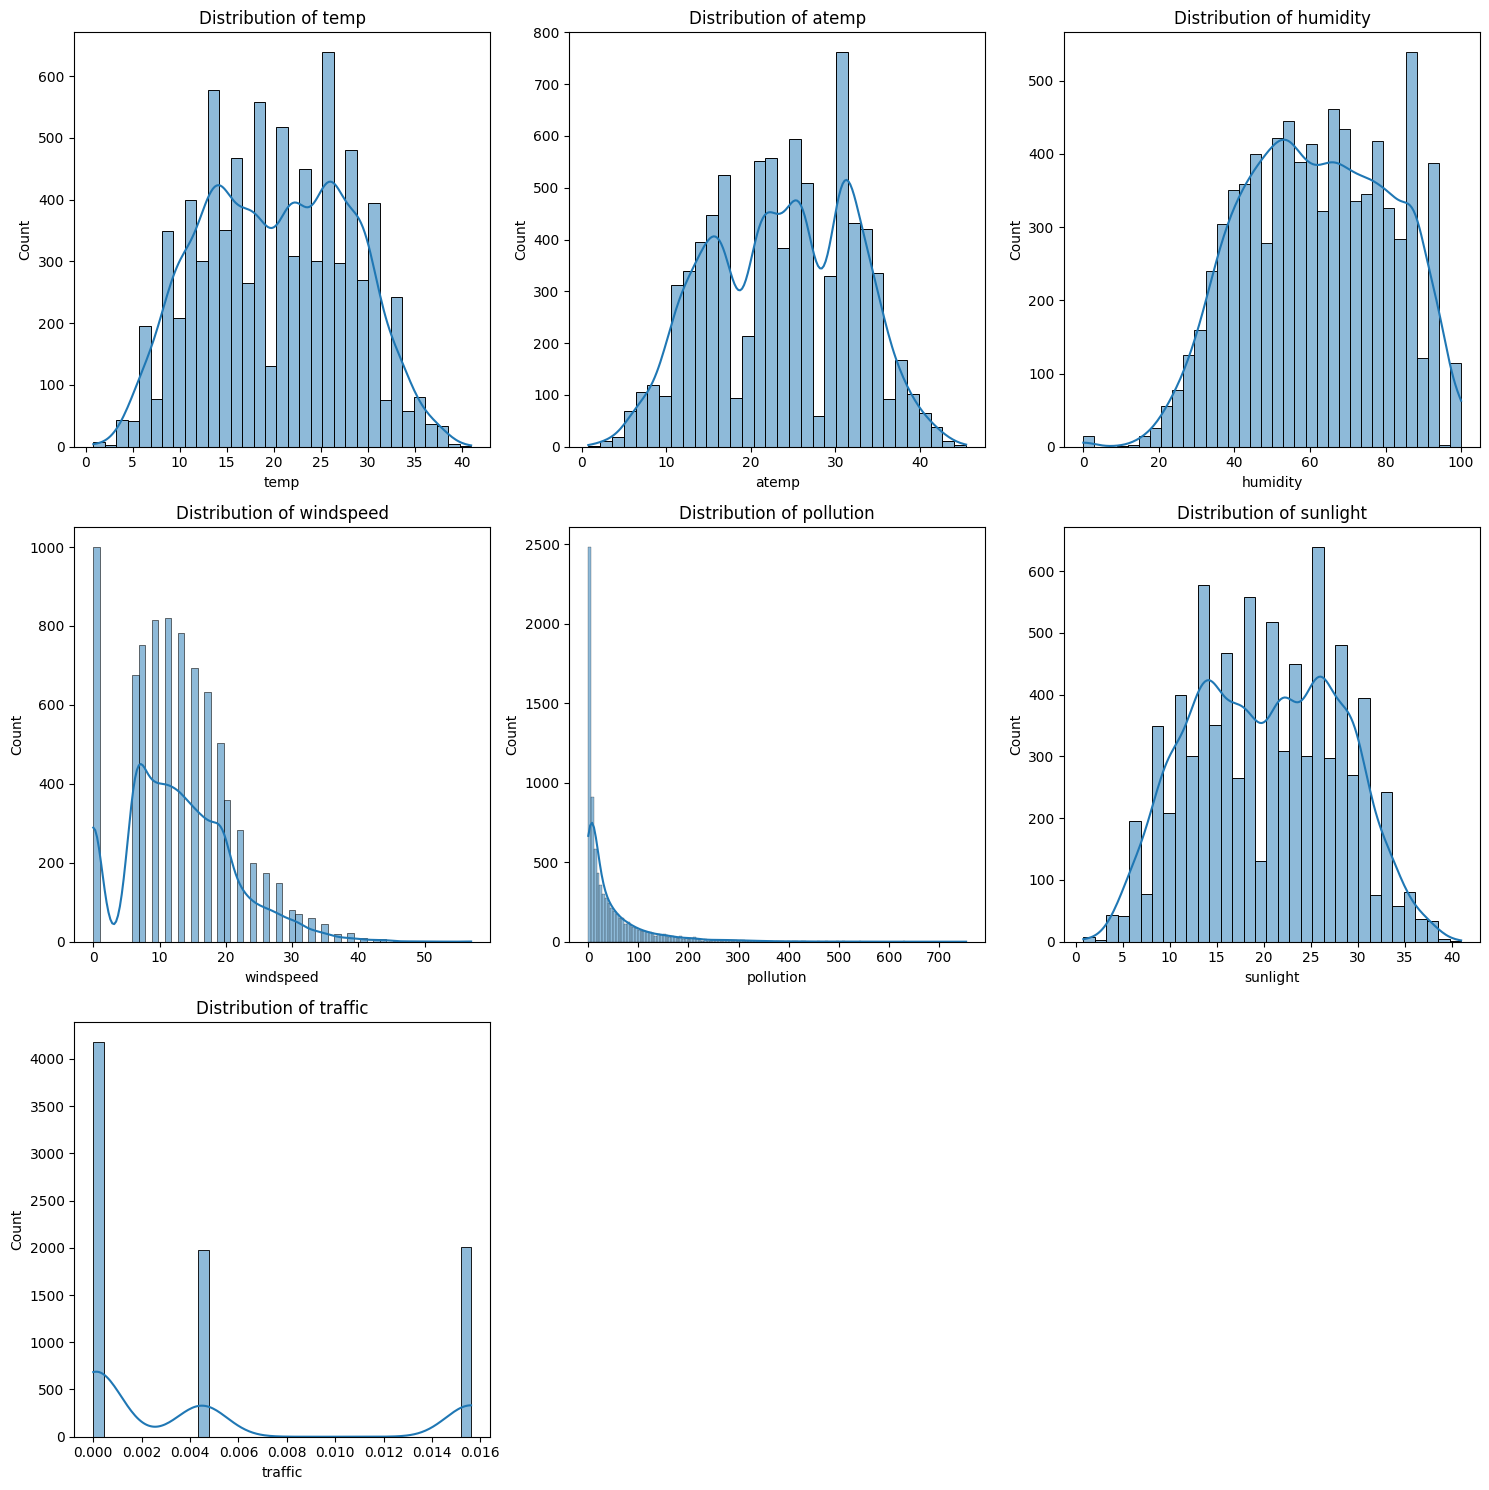

In [10]:
def selected_feature_dist(df, features):
    num_features = len(features)

    num_rows = (num_features - 1) // 3 + 1
    num_cols = min(num_features, 3)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

    # Flatten the axes to handle cases with fewer features than subplots
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.histplot(df[feature], kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {feature}")

    # Remove empty subplots if there are any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


selected_feature_dist(train_raw, continuous_columns)

We employed both histogram and Kernel Density Estimation (KDE) plots to visualize the numeric feature distribution. By looking at these plots, we can see patterns and outliers, helping us understand the data.
Notably, a visual inspection suggests that the features are not normally distributed. <br>

At first, we used ChatGPT to help us creating informative numeric distribution graphs. However, the initial implementation resulted in empty subplots when the number of features was less than the allocated plot space. Recognizing this issue, we iteratively improved the code by adjusting the number of rows and columns, ensuring a visually good-looking and informative graph without any empty subplots.

**Box-plot:**

In [11]:
def display_box_plot(df,feature_list):
    for feature in feature_list:
        fig = px.box(df,y=feature, title=f"Distrubution of {feature}:")
        fig.update_layout(height=500, width=500)
        fig.show()

display_box_plot(train_raw, continuous_columns)

We decided to use a Box Plot as it is a valuable tool for identification of outliers.<br>
As we can see there are extreme values in some of our features: windspeed, pollution, humidity.

### Graphical representation of the amount of bicycles rented according to categorical variables



The 'show_feature_dist' function  generates and displays bar charts illustrating the distribution of bike rentals across different categories of the specified categorical features. The charts provide insights into how bike rentals vary based on seasons and weather conditions.

In [12]:
def show_feature_dist(df, feature):
    plt.figure(figsize=(3,3))
    grouped_counts = df.groupby(feature)['count'].sum().reset_index(name='Total_Count')

    fig = px.bar(grouped_counts, x=feature, y='Total_Count', color='Total_Count',
                labels={feature: feature, 'Total_Count': 'Total Count'},
                title=f'Total Count of bikes rented for each {feature}')

    fig.show()

categorical_feature_list = ['season', 'weather']

for feature in categorical_feature_list:
    show_feature_dist(train_raw,feature)


<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

From the graphs we learn that the observed patterns suggest a strong correlation between bike rentals and weather conditions, with clear and mild weather encouraging higher bike usage, while adverse conditions, especially during winter, result in decreased demand for bike rentals.

Now, we will execute the same code on the features 'holiday' and 'workingday', aiming to gain insights into how bike usage fluctuates in relation to holidays and working days.

In [13]:
binary_feature_list = ['holiday', 'workingday']

for feature in binary_feature_list:
    show_feature_dist(train_raw,feature)

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

The analysis of the graphs indicates a clear preference for bike rentals on working days and during non-holiday periods. It appears that individuals are more inclined to utilize bike-sharing services as part of their routine activities, particularly for commuting or daily tasks.


The objective of the function 'show_temperature_dist' is to unveil the correlation between temperature and bike rentals. This is achieved by categorizing temperature values into specific groups and subsequently visualizing the rental patterns within each temperature category. The resulting bar chart provides an insightful representation of how variations in temperature relate to the total count of bike rentals, offering a clear perspective on the impact of temperature on bike usage.


In [14]:
def show_temperature_dist(df):
    plt.figure(figsize=(3,3))

    # Create temperature groups
    temperature_bins = list(range(0, 41, 5))
    temperature_labels = [f'{i}-{i+5}' for i in range(0, 40, 5)]

    grouped_counts = df.groupby(pd.cut(df['temp'], bins=temperature_bins, labels=temperature_labels, right=False))['count'].sum().reset_index(name='Total_Count')

    fig = px.bar(grouped_counts, x='temp', y='Total_Count', color='Total_Count',
                labels={'temp': 'Temperature Group', 'Total_Count': 'Total Count'},
                title='Total Count of bikes rented for each Temperature Group')

    fig.update_xaxes(categoryorder='array', categoryarray=temperature_labels)  # To order x-axis categories
    fig.show()

show_temperature_dist(train_raw)



<Figure size 300x300 with 0 Axes>

The analysis of bike rental patterns across temperature groups reveals intriguing insights. The highest demand for bike rentals is observed in the temperature range of 25-30 degrees Celsius, suggesting an optimal and comfortable weather condition for outdoor activities like cycling. Interestingly, extreme temperatures, both very cold (0-10 degrees Celsius) and very hot (35-40 degrees Celsius), are associated with a notable decrease in bike rentals. This indicates a potential aversion to biking during harsh weather conditions, highlighting the preference for moderate temperatures.

## Plotting total bike rentals by hour of the day


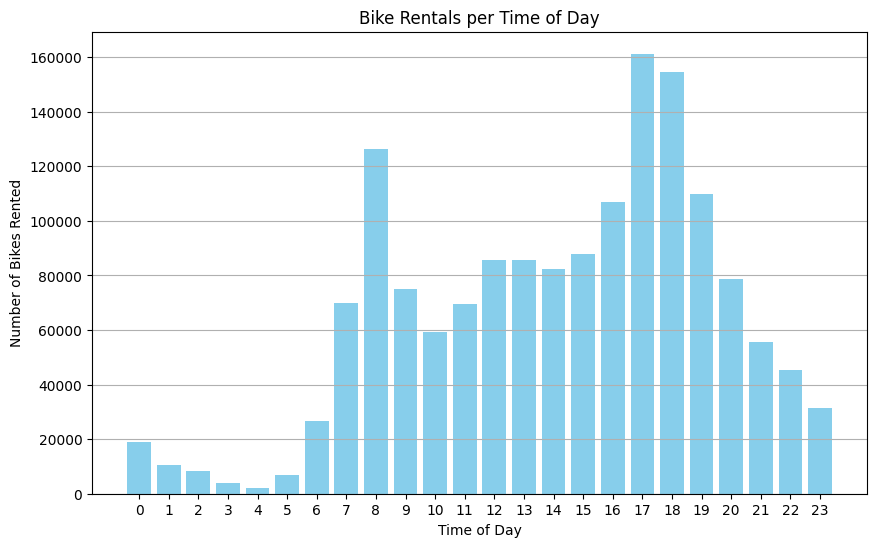

In [15]:
train_raw['datetime'] = pd.to_datetime(train_raw['datetime'], format='%Y-%m-%d %H:%M:%S')


train_raw['time_of_day'] = train_raw['datetime'].dt.hour
time_of_day_counts = train_raw.groupby('time_of_day')['count'].sum()


plt.figure(figsize=(10, 6))
plt.bar(time_of_day_counts.index, time_of_day_counts.values, color='skyblue')
plt.xlabel('Time of Day')
plt.ylabel('Number of Bikes Rented')
plt.title('Bike Rentals per Time of Day')
plt.xticks(range(24))
plt.grid(axis='y')


plt.show()

train_raw = train_raw.drop('time_of_day', axis=1)


As can be seen by the Bar Plot, the time of day affects the amount of bikes rented.

These results make sense, as it is likely that in the early morning (8 am) rentals are higher (for example: work commute) than later morning hours. For the same reason we can see EOD hours (17-18) with the most rentals.


Therefore, we will use this column as a feature later in our models.

### Plot total bike rentals by month

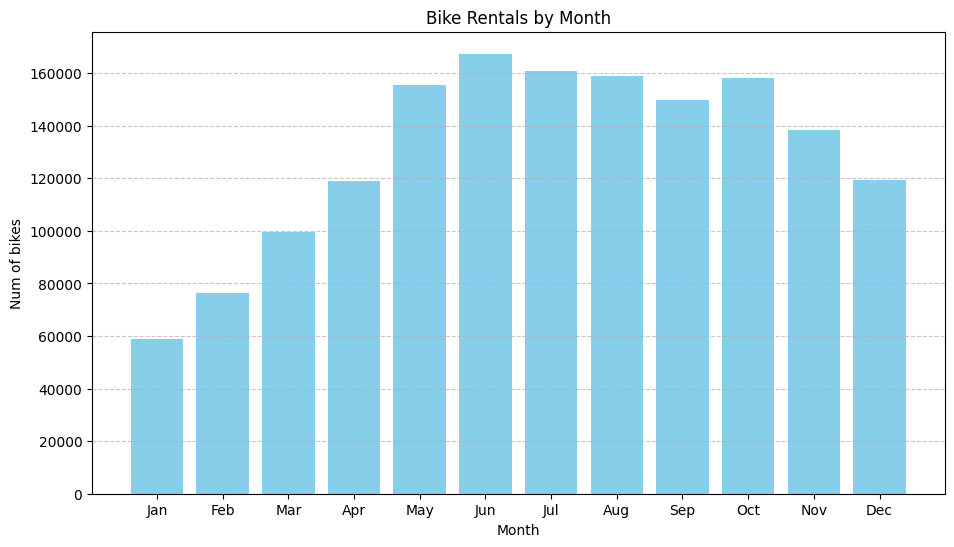

In [16]:
train_raw['datetime'] = pd.to_datetime(train_raw['datetime'], format='%Y-%m-%d %H:%M:%S')


train_raw['month'] = train_raw['datetime'].dt.month
monthly_counts = train_raw.groupby('month')['count'].sum()

plt.figure(figsize=(11, 6))
plt.bar(monthly_counts.index, monthly_counts.values, color='skyblue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Num of bikes')
plt.title('Bike Rentals by Month')
plt.xlabel('Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

train_raw = train_raw.drop('month', axis=1)



As can be seen by the Bar Plot, the current month affects the amount of bikes rented.

Hotter months such in the Summer have a higher rental count, while certain months of this season (June-August) have higher rentals than May (a Summer month) likely due to Summer break for schools starting in June.

Months such as March-April have low rentals due to rainy weather, while colder months such as January,February, and December also have lower rental counts.

After observing the significance of this data, we will use this column as a feature later in our models.

###Missing Values

In [17]:
missing_values = train_raw.isnull().sum()
print(missing_values)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
pollution     0
sunlight      0
traffic       0
count         0
dtype: int64


Addressing missing values in data tables is crucial for maintaining data quality, ensuring accurate model performance, and avoiding biased analyses. Missing values can lead to errors in algorithms and hinder the understanding of dataset patterns, impacting overall results.

Fortunately, our dataset has no missing values so no further processing is required.




## Correlation


<Axes: title={'center': 'Pearson Correlation Heatmap'}>

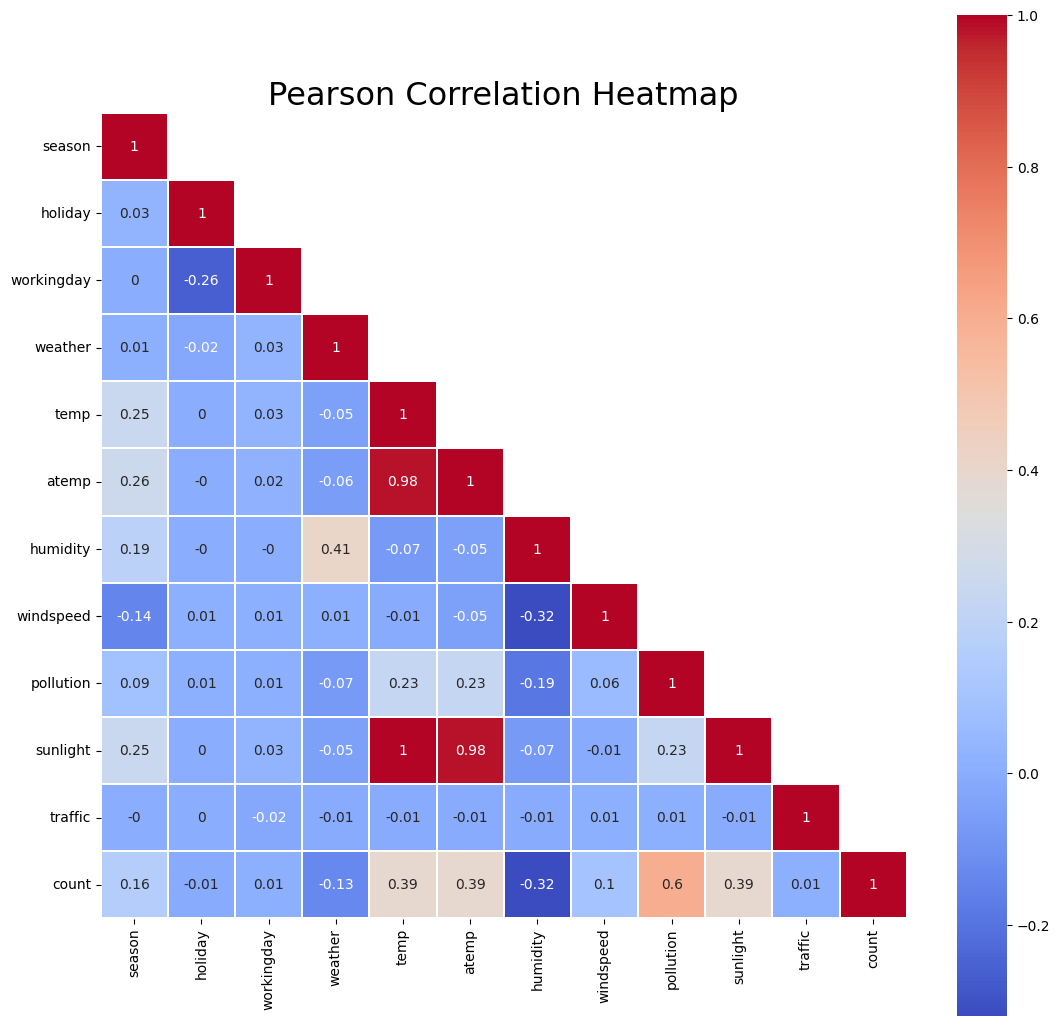

In [18]:
correlations = train_raw.corr(numeric_only=True).round(2)

mask = np.zeros_like(correlations, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

fig, ax = plt.subplots(figsize=(13, 13))
plt.title('Pearson Correlation Heatmap', fontsize=23)

sns.heatmap(correlations, linewidths=0.25, vmax=1.0, square=True, cmap="coolwarm",
            linecolor='w', annot=True, mask=mask)

Key Observations:

*Temperature (temp) and Apparent Temperature (atemp)*: There is a very high positive correlation (0.98), which is expected since apparent temperature is usually derived from the actual temperature, often adjusted for humidity or wind chill.

*Sunlight and Temperature (temp)*: A perfect correlation (1), which suggests that as sunlight increases, the temperature tends to increase as well, which is consistent with general weather patterns.

**Therefore we will later choose to keep only one of these features.**

*Humidity and Windspeed*: There is a moderate negative correlation (-0.32), suggesting that higher humidity levels might be associated with lower wind speeds.

In addition, we can see that traffic has a very low correlation with count (0.01).  This will also be addressed later.

# Initial Models

We split the data into training and validation tests in order to evaluate our models later.

In [19]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_raw,Y_train_raw,test_size = 0.2, random_state = 42)


In [20]:
models = {'Random forest': None,
          'XGboost': None,
          'Linear regression': None}

In [21]:
#Runtime Dictionary

runtimes = {'Random forest': None,
          'XGboost': None,
          'Linear regression': None}

### Random forest

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [23]:
def run_random_forest(x_train, y_train):

  global runtimes
  start_time = time.time()  # Record the start time

  rf = RandomForestRegressor(random_state=42)
  tuned_rf = GridSearchCV(estimator=rf,
                          param_grid= {'n_estimators': [300,400],
                          'max_depth': [30,40,50],
                          'min_samples_split': [3, 4, 5]
                          },
                          scoring='neg_mean_squared_error',
                          cv=3,
                          verbose=3,
                          refit=True)
  tuned_rf.fit(x_train, y_train)

  end_time = time.time()  # Record the end time
  runtime = end_time - start_time  # Calculate the runtime

  runtimes['Random forest'] = runtime

  return tuned_rf

### XGBoost

In [24]:
from xgboost import XGBRegressor

In [25]:
def run_xgboost(x_train, y_train):
    global runtimes

    start_time = time.time()  # Record the start time

    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

    tuned_xgb = GridSearchCV(estimator=xgb,
                             param_grid={'max_depth': [3, 5, 7],
                                         'learning_rate': [0.01, 0.1, 0.2],
                                         'n_estimators': [50, 100, 200]},
                             scoring='neg_mean_squared_error',
                             cv=3,
                             verbose=3,
                             refit=True)

    tuned_xgb.fit(x_train, y_train)

    end_time = time.time()  # Record the end time
    runtime = end_time - start_time  # Calculate the runtime


    runtimes['XGboost'] = runtime


    return tuned_xgb

### Linear Regression


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [27]:
def run_linear_regression(x_train, y_train):
  global runtimes
  start_time = time.time()  # Record the start time

  lr = LinearRegression()
  lr.fit(x_train, np.ravel(y_train))
  cv_score = cross_val_score(lr, x_train, y_train, scoring='neg_mean_squared_error', cv=3)

  end_time = time.time()  # Record the end time
  runtime = end_time - start_time  # Calculate the runtime

  runtimes['Linear regression'] = runtime
  return lr, cv_score

### Function to run all models

In [28]:
def run_all_models(x, y):
  models_dict = {}
  models_dict['Random forest'] = run_random_forest(x, y)
  models_dict['XGboost'] = run_xgboost(x, y)
  models_dict['Linear regression'] = run_linear_regression(x, y)
  return models_dict

In [29]:
models = run_all_models(X_train.drop(['datetime'],axis=1), y_train.values.ravel())

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END max_depth=30, min_samples_split=3, n_estimators=300;, score=-16476.453 total time=  11.6s
[CV 2/3] END max_depth=30, min_samples_split=3, n_estimators=300;, score=-14963.539 total time=  10.7s
[CV 3/3] END max_depth=30, min_samples_split=3, n_estimators=300;, score=-16483.180 total time=   6.3s
[CV 1/3] END max_depth=30, min_samples_split=3, n_estimators=400;, score=-16465.804 total time=   7.7s
[CV 2/3] END max_depth=30, min_samples_split=3, n_estimators=400;, score=-14878.438 total time=   8.1s
[CV 3/3] END max_depth=30, min_samples_split=3, n_estimators=400;, score=-16508.546 total time=  10.4s
[CV 1/3] END max_depth=30, min_samples_split=4, n_estimators=300;, score=-16461.572 total time=   7.5s
[CV 2/3] END max_depth=30, min_samples_split=4, n_estimators=300;, score=-14924.667 total time=   6.8s
[CV 3/3] END max_depth=30, min_samples_split=4, n_estimators=300;, score=-16445.567 total time=   6.0s
[CV 1/3] END

### Evaluating single model function

We will use this for prediction later

In [3]:
from sklearn.metrics import mean_squared_error

def evaluate_single_model(x, y, model):
  global runtime
  start_time = time.time()  # Record the start time

  y_pred = model.predict(x)
  end_time = time.time()  # Record the end time
  runtime = end_time - start_time  # Calculate the runtime

  return np.sqrt(mean_squared_error(y, y_pred)),runtime

In [30]:
trained_models_dict = {}
trained_models_dict['Random forest'] = models['Random forest'].best_estimator_
trained_models_dict['XGboost'] = models['XGboost'].best_estimator_
trained_models_dict['Linear regression'] = models['Linear regression'][0]
trained_models_dict

{'Random forest': RandomForestRegressor(max_depth=30, min_samples_split=5, n_estimators=400,
                       random_state=42),
 'XGboost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'Linear regression': LinearRegression()}

In [31]:
def evaluate_all_models(x, y, models_dict):
  test_set_scores = {}
  for k, v in models_dict.items():
    test_set_scores[k] = evaluate_single_model(x, y, v)
  return test_set_scores

In [76]:
val_set_scores = evaluate_all_models(X_validation.drop(['datetime'],axis=1), y_validation, trained_models_dict)


for key, value in val_set_scores.items():
    print(f"{key}: {value[0]}")

KeyError: "['datetime'] not found in axis"

These inital results are very high, but this makes sense as we have not done any preprocessing on our data.

# Preprocessing

### Dealing with Datetime

This feature is arguibly the most important and needs special attenton due to its nature. The format in which datetime is given is not of one type therefore we need to extract all relevant data to properly assess the effects of the time and date in which bikes were rented.

As explained in the hours histogram, we use created an 'hours' column in order to factor the effect of the hour of the day on rentals.

In addition, using trigonometric functions like sine or cosine on time features is a common technique in time series analysis and machine learning when dealing with cyclical patterns, such as daily or yearly cycles. The idea is to represent the time of day as a cyclic feature rather than a linear one.

If we create an hourly time feature, this helps the model understand the cyclical nature of time, preventing it from interpreting 23:00 and 00:00, for instance, as being far apart.

Lastly, we created a 'sin_of_month' column in order to include the effect different months of the year have on bike rentals (as seen in the histogram beforehand). Similar to hours, months are also cyclic and the Sin function can also be used to increase the accuracy of our data.


In [33]:
def datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

    # Create a new column for the sin(month)
    df['sin_of_month'] = np.sin(np.radians(df['datetime'].dt.month))


    # Create a new column for the sin(hour)
    df['sin_of_hour'] = np.sin(np.radians(df['datetime'].dt.hour))

    return df

X_train = datetime(X_train)

X_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,sin_of_month,sin_of_hour
6913,2012-05-19 03:00:00,2,0,0,1,20.50,24.240,48,7.0015,13.327268,20.501,0.000242,0.087156,0.052336
7753,2012-12-07 12:00:00,4,0,1,2,13.94,16.665,71,12.9980,11.678911,13.941,0.004489,0.207912,0.207912
3780,2012-08-14 07:00:00,3,0,1,2,27.06,30.305,83,6.0032,95.329124,27.061,0.015615,0.139173,0.121869
6710,2011-04-16 22:00:00,2,0,0,3,17.22,21.210,100,0.0000,9.297959,17.221,0.000000,0.069756,0.374607
4955,2012-01-14 06:00:00,1,0,0,1,5.74,7.575,50,0.0000,0.094263,5.741,0.000000,0.017452,0.104528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2012-02-05 14:00:00,1,0,0,1,12.30,15.150,61,11.0014,3.068827,12.301,0.000000,0.034899,0.241922
5390,2011-04-14 01:00:00,2,0,1,1,15.58,19.695,76,15.0013,1.976179,15.581,0.000242,0.069756,0.017452
860,2011-12-07 10:00:00,4,0,1,3,18.04,21.970,100,6.0032,4.960762,18.041,0.000000,0.207912,0.173648
7603,2011-12-15 03:00:00,4,0,1,2,13.12,16.665,70,8.9981,0.073546,13.121,0.000000,0.207912,0.052336


In [34]:
#remove datetime as no longer needed
X_train = X_train.iloc[:,1:]

We put the datetime column on the side, as it is no longer needed

##Outliers

To address extreme values within our dataset, we utilize the 'outliers' function. Employing a percentile-based strategy to identify outliers in specified features, the function considers both upper and lower thresholds. Values exceeding the 98th percentile or falling below the 2nd percentile for each feature are flagged as outliers. If the boolean flag is set to True, detailed information, including upper and lower values and the count of outliers removed, is printed for each feature. Subsequently, these outliers are replaced with the median of the corresponding feature. Properly handling outliers is vital for maintaining the integrity of results, particularly when extreme values can unduly influence statistical measures and model outcomes.

In [35]:
def outliers(df, bool_print, features):
    for feature in features:
        x = df[feature]

        # Calculate upper and lower percentiles
        upper = np.percentile(x, 98)
        lower = np.percentile(x, 2)

        if bool_print:
            print(f"Upper value of feature '{feature}' is {upper}")
            print(f"Lower value of feature '{feature}' is {lower}")

        # Identify outliers
        outliers_upper = x > upper
        outliers_lower = x < lower
        outliers = outliers_upper | outliers_lower

        if bool_print:
            print(f"{feature} - Amount of Outliers removed: {sum(outliers)}\n")

        # Remove outliers and fill NaN with the median
        df[feature] = df[feature].where(~outliers, np.nan)
        df[feature].fillna(df[feature].median(), inplace=True)

    return df


In [36]:
numeric_features = ['humidity', 'windspeed', 'pollution']

X_outliers_train = outliers(X_train,True, numeric_features)

Upper value of feature 'humidity' is 94.0
Lower value of feature 'humidity' is 25.0
humidity - Amount of Outliers removed: 222

Upper value of feature 'windspeed' is 32.9975
Lower value of feature 'windspeed' is 0.0
windspeed - Amount of Outliers removed: 92

Upper value of feature 'pollution' is 290.79288949467735
Lower value of feature 'pollution' is 0.0910708693882946
pollution - Amount of Outliers removed: 262



As seen in the exploration phase, there existed outliers mainly in 3 features - 'humidity', 'windspeed' and 'pollution'. Therefore, we chose to remove outliers only in these features.


Now, we will visualize the distribution of features once again to observe the distinct impact of the outlier handling process

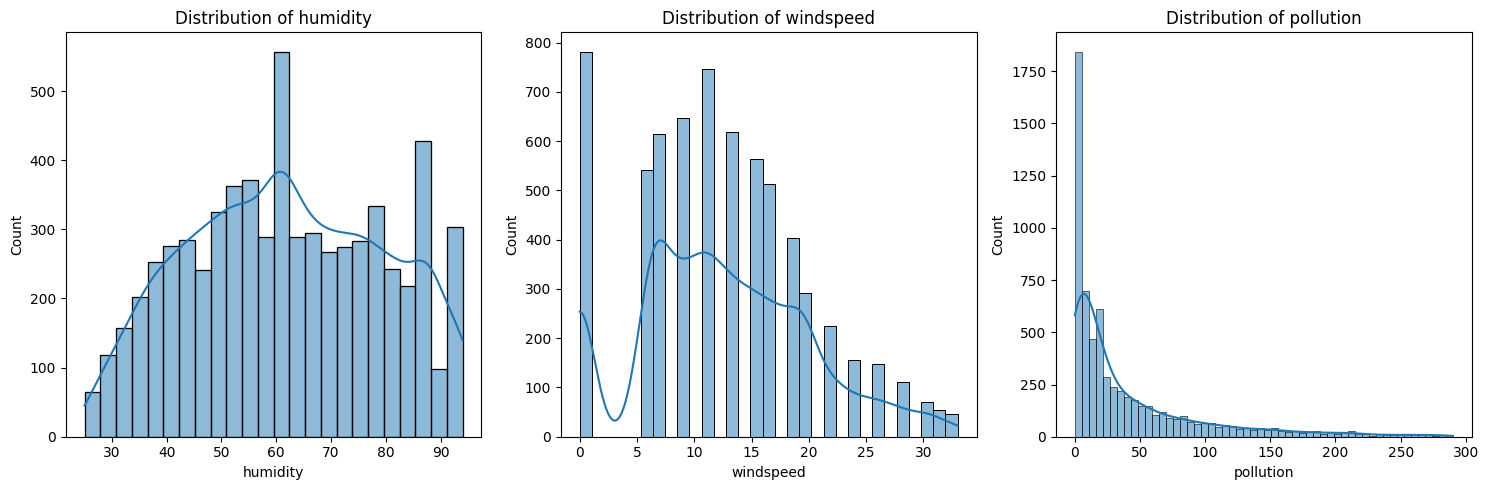

In [37]:
selected_feature_dist(X_outliers_train, numeric_features)

In [38]:
display_box_plot(X_outliers_train,numeric_features)

As evident from the updated visualizations, the handling of outliers proves to be crucial, leading to a substantial reduction in the presence of extreme values within the features.

##Feature Engineering

We decided to remove 'traffic' since this feature has little to no explainability. A seen before in the correlation matrix, traffic and count have a 0.01 correlation factor. In addition, this feature does not contain any sense of scale. For example, 0.044 traffic. If this was out of 1, than we could understand how much traffic there really is. Unfortunately, the lack of scale could lead to many interpretations of the amount of traffic that this is actually valued at.

Additionaly, due to reasons explained earlier in the correlation matrix, we removed 'atemp' and 'sunlight'

In [39]:
X_notraffic = X_outliers_train.drop(['traffic'], axis=1)
X_noatemp = X_notraffic.drop(['atemp'], axis=1)
X_nosun = X_noatemp.drop(['sunlight'], axis=1)

## Normalization

We chose to use MinMax scaler as it transforms our numerical values to values between [0,1]. This vastly helps with for readability/explainability of our models and with scale.

This form of scaling is more relevant to us in contrast to standard scaler which is more relevant for deep learning models and PCA, which were are not using in this assignment.




We create a data type called 'categorial' in order to not normalize the binary and categorical values.

Also, there is no reason to touch sin(hour) since it is already between [0,1]


In [40]:
def convert_to_categorical(data):
    categorical_features = ['weather', 'season', 'workingday', 'holiday','sin_of_month','sin_of_hour']

    for feature in categorical_features:
        data[feature] = data[feature].astype('category')

    return data

X_converted = convert_to_categorical(X_nosun)

X_converted.dtypes



season          category
holiday         category
workingday      category
weather         category
temp             float64
humidity         float64
windspeed        float64
pollution        float64
sin_of_month    category
sin_of_hour     category
dtype: object

In [41]:
from sklearn.preprocessing import MinMaxScaler

#numeric features list

numeric_features = X_nosun.select_dtypes(include=['float64', 'int64']).columns

def min_max_scaling(train,numeric_features):

    scaler = MinMaxScaler()
    train[numeric_features] = scaler.fit_transform(train[numeric_features])
    return train, scaler

X_scaled,scaler = min_max_scaling(X_converted,numeric_features)

Convert types back to respective data types

In [42]:
def convert_back(data):
    categorical_features = ['weather', 'season', 'workingday', 'holiday']
    data['sin_of_month'] = data['sin_of_month'].astype('float64')
    data['sin_of_hour'] = data['sin_of_hour'].astype('float64')
    for feature in categorical_features:
        data[feature] = data[feature].astype('int64')

    return data

X_scaled = convert_back(X_scaled)

X_scaled.dtypes

season            int64
holiday           int64
workingday        int64
weather           int64
temp            float64
humidity        float64
windspeed       float64
pollution       float64
sin_of_month    float64
sin_of_hour     float64
dtype: object

In [43]:
X_scaled

,season,holiday,workingday,weather,temp,humidity,windspeed,pollution,sin_of_month,sin_of_hour
6913,2,0,0,1,0.510638,0.333333,0.212183,0.045654,0.087156,0.052336
7753,4,0,1,2,0.340426,0.666667,0.393909,0.039968,0.207912,0.207912
3780,3,0,1,2,0.680851,0.840580,0.181929,0.328506,0.139173,0.121869
6710,2,0,0,3,0.425532,0.521739,0.000000,0.031755,0.069756,0.374607
4955,1,0,0,1,0.127660,0.362319,0.000000,0.000008,0.017452,0.104528
...,...,...,...,...,...,...,...,...,...,...
5226,1,0,0,1,0.297872,0.521739,0.333401,0.010269,0.034899,0.241922
5390,2,0,1,1,0.382979,0.739130,0.454619,0.006500,0.069756,0.017452
860,4,0,1,3,0.446809,0.521739,0.181929,0.016795,0.207912,0.173648
7603,4,0,1,2,0.319149,0.652174,0.272690,0.061638,0.207912,0.052336


## One-Hot Encoding
Here, we implemented a custom one-hot encoding method for 'season' and 'weather'. One-hot encoding is used for improving model interpretability of categorial features.

For this function, Chat GPT was used to make the function more accurate. At first, since our validation data does not have any 'weather' values as '4' a column for 'Heavy_rain' was not created. GPT helped us add fill_missing_with zeroes and overall streamline the function to work given any data.


In [44]:
def custom_one_hot_encoding(df, mappings, drop_original=True, fill_missing_with_zeros=True):

    df_encoded = df.copy()

    for column, mapping in mappings.items():
        # Map the column to the corresponding custom names
        df_encoded[column] = df_encoded[column].map(mapping)

        # Perform one-hot encoding on the specified column with custom feature names
        df_encoded = pd.concat([df_encoded, pd.get_dummies(df_encoded[column], prefix='', prefix_sep='')], axis=1)

        if drop_original:
            df_encoded = df_encoded.drop(columns=[column])

        # Fill missing features with zeros if specified
        if fill_missing_with_zeros:
            missing_features = set(mapping.values()) - set(df_encoded.columns)
            for feature in missing_features:
                df_encoded[feature] = 0

    return df_encoded


season_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
weather_mapping = {1: 'Clear_Weather', 2: 'Cloudy', 3: 'Light_Snow', 4: 'Heavy_Rain'}

# Apply custom one-hot encoding function to the specified columns
X_one_hot = custom_one_hot_encoding(X_scaled, {'season': season_mapping, 'weather': weather_mapping})

# Move the specified column to the last position
X_one_hot = pd.concat([X_one_hot.drop('Heavy_Rain', axis=1), X_one_hot['Heavy_Rain']], axis=1)




In [45]:
X_train = X_one_hot

# Validation preprocessing

This pipeline is used to preprocess our test/validation datasets using learned values from our training set.

In [46]:
def preprocess_val(X_val,numeric_features,scaler,season_mapping,weather_mapping):


    #X_val = time_of_day(X_val)
    X_val = datetime(X_val)

    #remove datetime
    X_val = X_val.iloc[:,1:]

    #remove traffic
    X_val = X_val.drop(['traffic'], axis=1)

    #remove atemp,sunlight

    X_val = X_val.drop(['atemp'], axis=1)
    X_val = X_val.drop(['sunlight'], axis=1)

    #normalize
    X_val = convert_to_categorical(X_val)
    X_val[numeric_features] = scaler.transform(X_val[numeric_features])
    X_val = convert_back(X_val)

    X_val = custom_one_hot_encoding(X_val, {'season': season_mapping, 'weather': weather_mapping})
    return X_val

X_validation = preprocess_val(X_validation,numeric_features,scaler,season_mapping,weather_mapping)

In [47]:
X_validation

,holiday,workingday,temp,humidity,windspeed,pollution,sin_of_month,sin_of_hour,fall,spring,summer,winter,Clear_Weather,Cloudy,Light_Snow,Heavy_Rain
7165,0,0,0.638298,0.521739,0.212183,0.025590,0.104528,0.104528,0,1,0,0,0,1,0,0
3862,0,1,0.617021,0.768116,0.393909,0.011932,0.104528,0.390731,0,1,0,0,0,0,1,0
3307,0,1,0.361702,0.463768,0.454619,0.129852,0.207912,0.342020,1,0,0,0,1,0,0,0
2492,0,0,0.829787,0.347826,1.727310,0.188973,0.121869,0.309017,0,0,1,0,0,0,1,0
6783,0,1,0.510638,0.753623,0.181929,0.026958,0.173648,0.374607,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,0,1,0.680851,0.202899,0.515127,0.031807,0.052336,0.241922,0,0,0,1,1,0,0,0
7311,0,1,0.680851,0.028986,0.333401,0.189904,0.087156,0.309017,0,1,0,0,1,0,0,0
7243,0,1,0.127660,0.637681,0.272690,0.053441,0.017452,0.121869,0,0,0,1,1,0,0,0
4582,0,1,0.297872,0.579710,0.393909,0.142760,0.034899,0.121869,0,0,0,1,0,1,0,0


# Model Evaluation

In [48]:
models = {'Random forest': None,
          'XGboost': None,
          'Linear regression': None}

In [49]:
models = run_all_models(X_train, y_train.values.ravel())

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END max_depth=30, min_samples_split=3, n_estimators=300;, score=-6169.094 total time=   5.5s
[CV 2/3] END max_depth=30, min_samples_split=3, n_estimators=300;, score=-5614.271 total time=   6.1s
[CV 3/3] END max_depth=30, min_samples_split=3, n_estimators=300;, score=-5521.500 total time=   5.5s
[CV 1/3] END max_depth=30, min_samples_split=3, n_estimators=400;, score=-6173.113 total time=   7.9s
[CV 2/3] END max_depth=30, min_samples_split=3, n_estimators=400;, score=-5600.406 total time=   7.5s
[CV 3/3] END max_depth=30, min_samples_split=3, n_estimators=400;, score=-5511.576 total time=   7.7s
[CV 1/3] END max_depth=30, min_samples_split=4, n_estimators=300;, score=-6163.128 total time=   6.1s
[CV 2/3] END max_depth=30, min_samples_split=4, n_estimators=300;, score=-5617.491 total time=   5.7s
[CV 3/3] END max_depth=30, min_samples_split=4, n_estimators=300;, score=-5507.169 total time=   5.2s
[CV 1/3] END max_dept

In [50]:
trained_models_dict = {}
trained_models_dict['Random forest'] = models['Random forest'].best_estimator_
trained_models_dict['XGboost'] = models['XGboost'].best_estimator_
trained_models_dict['Linear regression'] = models['Linear regression'][0]
trained_models_dict

{'Random forest': RandomForestRegressor(max_depth=30, min_samples_split=5, n_estimators=400,
                       random_state=42),
 'XGboost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'Linear regression': LinearRegression()}

In [86]:
validation_set_scores = evaluate_all_models(X_validation, y_validation, trained_models_dict)
validation_set_scores

for key, value in validation_set_scores.items():
    print(f"{key}: {value[0]}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Heavy_Rain
- spring
- summer


As seen in the results above, preprocessing is crucial in the machine learning process. Our results are greatly improved, and we can see that XGboost is the superior model, but not much more than Random Forest. This is because XGboost is similar to Random Forest and also uses gradient-boosted decision trees.

## Feature importance
In order to improve results, we will find the importance of all features for each model and remove insignificant features:

In [53]:
feature_importance_dict = {}

##Tree based methods
For tree based models we will use SKLearn's built-in methods:



In [54]:
def find_tree_feature_importance(model, columns):
  importance = model.feature_importances_
  importance *= 100 / np.max(importance)  # Normalize
  importance = pd.DataFrame(importance, index=columns, columns=["Importance"])
  importance = importance.sort_values(by=['Importance'], ascending=False)
  return importance

In [55]:
feature_importance_dict['Random forest'] = find_tree_feature_importance(trained_models_dict['Random forest'], X_train.columns)
feature_importance_dict['XGboost'] = find_tree_feature_importance(trained_models_dict['XGboost'], X_train.columns)


##Classical regression methods
One interpetation of feature importance for linear regression, is the normalized value of the estimator's coefficients:



In [56]:
def find_normalized_lr_feature_importance(model, x_train):
  coefficients = {x_train.columns[i]: np.abs(model.coef_[i]) for i in range(len(x_train.columns))}
  coefficients_df = pd.DataFrame.from_dict(coefficients, orient='index', columns=['Importance'])
  coefficients_df['Importance'] *=  x_train.std()
  coefficients_df['Importance'] *= 100 / coefficients_df['Importance'].max()
  importance = coefficients_df.sort_values(by=['Importance'], ascending=False)
  return importance


In [57]:
feature_importance_dict['Linear regression'] = find_normalized_lr_feature_importance(trained_models_dict['Linear regression'], X_train)

##Comparison
Let's visualize the different feature imprtance across the models

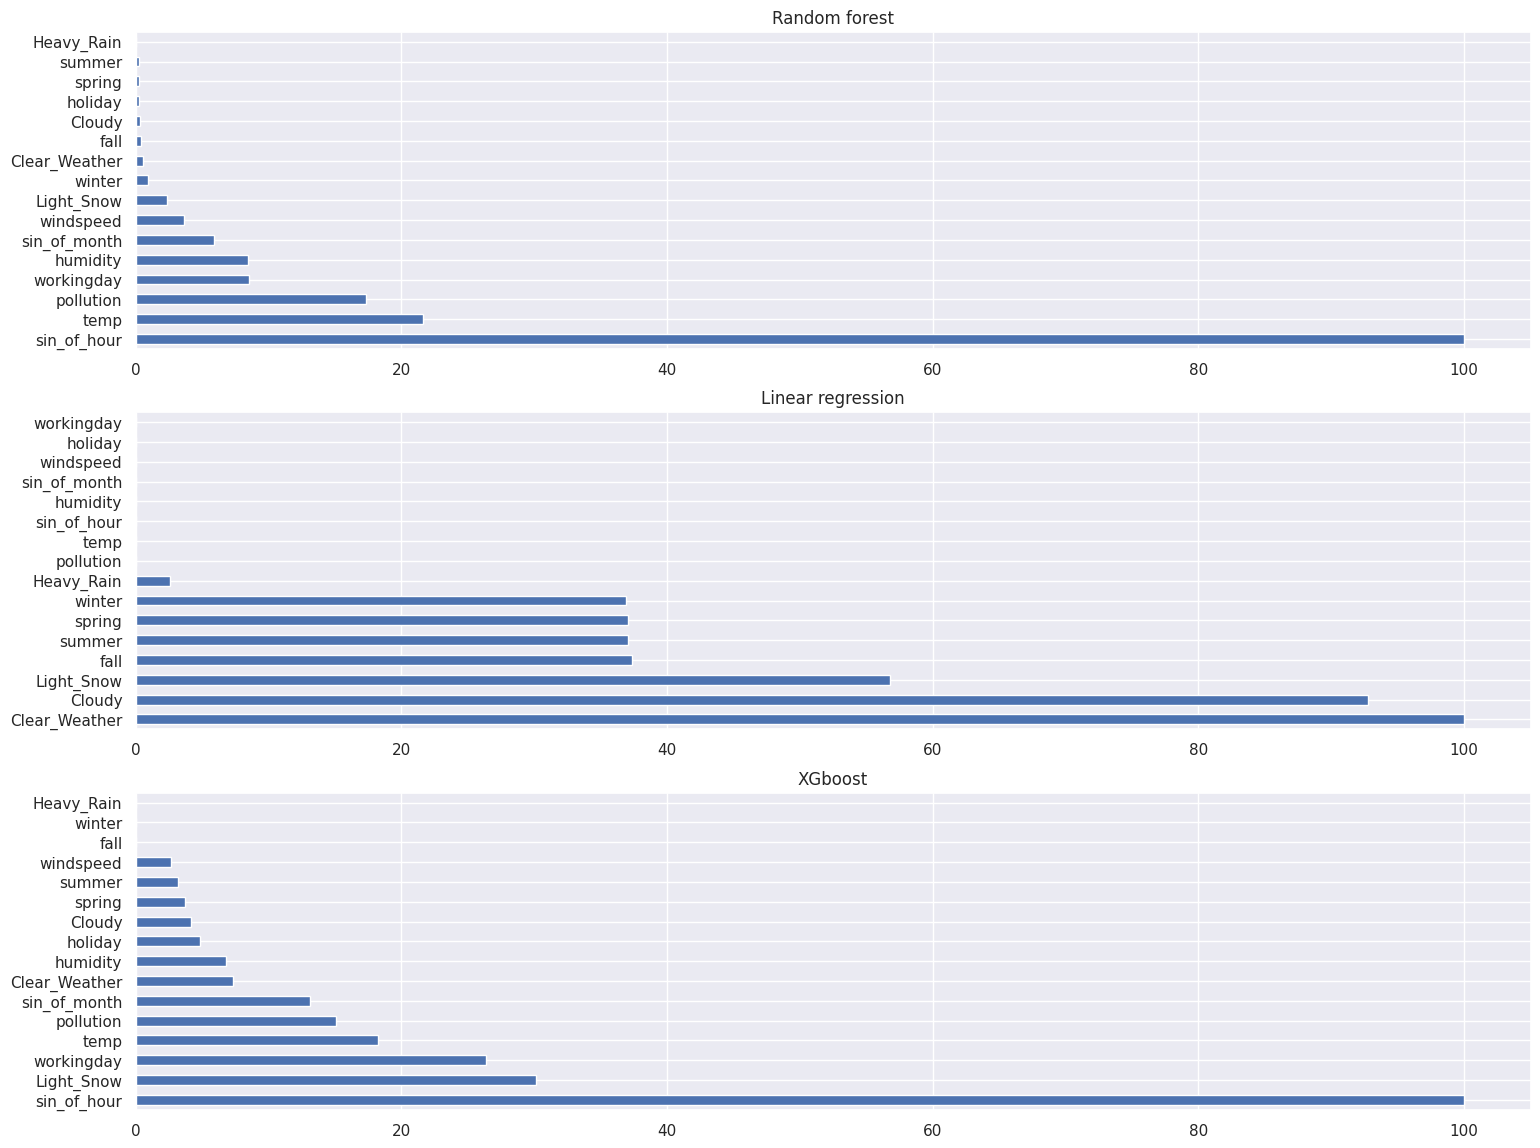

In [58]:
sns.set()

fig, axes = plt.subplots(3, 1, figsize=(18, 14))
feature_importance_dict['Random forest'].plot(kind='barh', ax=axes[0], legend=False, title='Random forest')
feature_importance_dict['Linear regression'].plot(kind='barh', ax=axes[1], legend=False, title='Linear regression')
feature_importance_dict['XGboost'].plot(kind='barh', ax=axes[2], legend=False, title='XGboost')

plt.show()

We can see that the top features for each model are:

Random Forest: 'pollution', 'temp', 'sin_of_hour'

XGboost: 'workingday', 'Light_snow', 'sin_of_hour'

Linear Regression: 'Light_Snow', 'Cloudy', 'Clear_Weather'

### Removing weak features
Let's find the 3 weakest features in each model

In [59]:
weak_features_dict = {}
for k, v in feature_importance_dict.items():
  weak_features_dict[k] = list(v.index.values[-3:])
weak_features_dict

{'Random forest': ['spring', 'summer', 'Heavy_Rain'],
 'XGboost': ['fall', 'winter', 'Heavy_Rain'],
 'Linear regression': ['windspeed', 'holiday', 'workingday']}

We now remove these features from each model. We create a dictionary mapping each model to X_train and X_validation without the last 3 features

In [80]:
x_data_dict = {}
for k, v in weak_features_dict.items():
  x_data_dict[k] = (X_train.drop(v, axis=1), X_validation.drop(v, axis=1))


Let's modify run_all_models to allow us to run on different datasets:



In [81]:
#save new runtimes
runtimes = {'Random forest': None,
          'XGboost': None,
          'Linear regression': None}

def run_all_models(x_dict, y):
  models_dict = {}
  models_dict['Random forest'] = run_random_forest(x_dict['Random forest'][0], y)
  models_dict['Linear regression'] = run_linear_regression(x_dict['Linear regression'][0], y)
  models_dict['XGboost'] = run_xgboost(x_dict['XGboost'][0], y)
  return models_dict

In [64]:
models = run_all_models(x_data_dict, y_train.values.ravel())
models

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END max_depth=30, min_samples_split=3, n_estimators=300;, score=-6161.831 total time=   5.3s
[CV 2/3] END max_depth=30, min_samples_split=3, n_estimators=300;, score=-5606.587 total time=   5.3s
[CV 3/3] END max_depth=30, min_samples_split=3, n_estimators=300;, score=-5510.389 total time=   5.7s
[CV 1/3] END max_depth=30, min_samples_split=3, n_estimators=400;, score=-6166.187 total time=   7.3s
[CV 2/3] END max_depth=30, min_samples_split=3, n_estimators=400;, score=-5589.110 total time=   7.4s
[CV 3/3] END max_depth=30, min_samples_split=3, n_estimators=400;, score=-5513.252 total time=   7.7s
[CV 1/3] END max_depth=30, min_samples_split=4, n_estimators=300;, score=-6173.203 total time=   5.5s
[CV 2/3] END max_depth=30, min_samples_split=4, n_estimators=300;, score=-5600.244 total time=   5.6s
[CV 3/3] END max_depth=30, min_samples_split=4, n_estimators=300;, score=-5515.077 total time=   4.9s
[CV 1/3] END max_dept

{'Random forest': GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
              param_grid={'max_depth': [30, 40, 50],
                          'min_samples_split': [3, 4, 5],
                          'n_estimators': [300, 400]},
              scoring='neg_mean_squared_error', verbose=3),
 'Linear regression': (LinearRegression(),
  array([-1.90024008e+04, -1.69091075e+04, -1.05226618e+28])),
 'XGboost': GridSearchCV(cv=3,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, im

In [65]:
#runtimes for train data
runtimes

{'Random forest': 371.4962091445923,
 'XGboost': 15.377435445785522,
 'Linear regression': 0.05548095703125}

In [82]:
print('Random forest Best Hyperparameters:', models['Random forest'].best_params_)
print('XGboost Best Hyperparameters:', models['XGboost'].best_params_)

Random forest Best Hyperparameters: {'max_depth': 40, 'min_samples_split': 4, 'n_estimators': 400}
XGboost Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [67]:
trained_models_dict = {}
trained_models_dict['Random forest'] = models['Random forest'].best_estimator_
trained_models_dict['XGboost'] = models['XGboost'].best_estimator_
trained_models_dict['Linear regression'] = models['Linear regression'][0]
trained_models_dict

{'Random forest': RandomForestRegressor(max_depth=40, min_samples_split=4, n_estimators=400,
                       random_state=42),
 'XGboost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'Linear regression': LinearRegression()}

In [68]:
def evaluate_all_models_dict(x_dict, y, models_dict):
  global runtimes
  test_set_scores = {}
  for k, v in models_dict.items():
    test_set_scores[k],runtimes[k] = evaluate_single_model(x_dict[k][1], y, v)
  return test_set_scores

In [85]:
val_set_scores = evaluate_all_models_dict(x_data_dict, y_validation, trained_models_dict)

val_set_scores

{'Random forest': 74.66051768443388,
 'XGboost': 70.93358264032216,
 'Linear regression': 126.48462749298506}

As we can see, dropping the 3 weakest features did not improve the results. We chose to keep this attempt, as we did not know beforehand of the results. In addition, this reduces our datas dimensions.

High dimensionality can pose several challenges:

Overfitting: With a large number of features, a model might fit the noise in the data rather than the underlying pattern. This makes the model perform well on the training set but poorly on unseen data.

Curse of Dimensionality: As the number of features (or dimensions) grows, the amount of data needed to generalize accurately grows exponentially.

Computational Complexity: More features require more computational resources (memory and processing power) to process and model.

Bias variance tradeoff: As learned in class, more dimensions means higher variance (but lower bias).

# Final Evaluation on Test Set

In [92]:
#access train from github
test = pd.read_csv('https://raw.githubusercontent.com/ronsegev98/Assignment_1_Group5/main/test.csv')

#Split into X,Y
X_test = test.drop(['count'], axis=1)
Y_test = test[['count']]


X_test = preprocess_val(X_test,numeric_features,scaler,season_mapping,weather_mapping)

In [94]:
#save new runtimes
runtimes = {'Random forest': None,
          'XGboost': None,
          'Linear regression': None}

#removing 3 weak features
x_data_dict_test = {}
for k, v in weak_features_dict.items():
  x_data_dict_test[k] = (X_train,X_test.drop(v, axis=1))

#evaluate scores
test_set_scores = evaluate_all_models_dict(x_data_dict_test, Y_test, trained_models_dict)
test_set_scores

{'Random forest': 70.47270299786557,
 'XGboost': 66.43437769613931,
 'Linear regression': 122.5875045472587}

Overall, these final results are even better than our first evaluation using our validation dataset. As we recieved a RMSE score lower than 70, this is considered a good model. With more time, we would be able to reduce this score with further preprocessing.

In [95]:
#runtimes for test data
runtimes

{'Random forest': 0.3693373203277588,
 'XGboost': 0.034833431243896484,
 'Linear regression': 0.011063098907470703}

## Hardware Utilization

CPUs offer versatility and single-threaded performance, GPUs excel at parallel computing and graphics-intensive tasks, and TPUs are the go-to choice for accelerating machine learning and deep learning workloads.

In this project, since we are did not run any neural networks as part of deep learning models, we did not use any GPU or TPU resources. CPU power was strictly used throughout this project.

# Convert Results to CSV

In [108]:
# Keep keys the same, and replace values according to your results and the specified type

#train runtimes
{'Random forest': 371.4962091445923,
 'XGboost': 15.377435445785522,
 'Linear regression': 0.05548095703125}

#test runtimes
{'Random forest': 0.3693373203277588,
 'XGboost': 0.034833431243896484,
 'Linear regression': 0.011063098907470703}

Random_forest_time = 371.49 + 0.36
XGboost_time = 15.37 + 0.034
Linear_regression_time = 0.055 + 0.011

results = {'model': ['Random forest', 'XGboost', 'Linear regression'],
           'Score (RMSE)': ['70.47', '66.43', '122.58'],
           'Hyperparams used': [['max_depth: 40', 'min_samples_split: 4', 'n_estimators: 400'], ['learning_rate: 0.1', 'max_depth: 7', 'n_estimators: 100'], ['fit_intercept=True', 'copy_X=True', 'n_jobs=None', 'positive=False']],
           'Features dropped': [['date_time', 'traffic', 'atemp', 'sunlight', 'season', 'weather','spring', 'summer', 'Heavy_Rain'], ['date_time', 'traffic', 'atemp', 'sunlight', 'season', 'weather','fall', 'winter', 'Heavy_Rain'], ['date_time', 'traffic', 'atemp', 'sunlight', 'season', 'weather','windspeed', 'holiday', 'workingday','windspeed', 'holiday', 'workingday']],
           'New features created': [['sin_of_hour', 'sin_month', 'winter', 'spring', 'summer', 'fall', 'clear_weather', 'cloudy', 'light_snow', 'heavy_rain'], ['sin_of_hour', 'sin_of_month', 'winter', 'spring', 'summer', 'fall', 'clear_weather', 'cloudy', 'light_snow', 'heavy_rain'], ['sin_of_hour', 'sin_of_month', 'winter', 'spring', 'summer', 'fall', 'clear_weather', 'cloudy', 'light_snow', 'heavy_rain']],
           'Runtime training + inference (seconds)': [f'{Random_forest_time}', f'{XGboost_time}', f'{Linear_regression_time}'],
           'Hardware used (GPU/CPU/TPU)': ['CPU', 'CPU', 'CPU'],
           'Explainability (top 3 features)': [['pollution', 'temp', 'sin_of_hour'], ['workingday', 'Light_snow', 'sin_of_hour'], ['Light_Snow', 'Cloudy', 'Clear_Weather']]
           }

df = pd.DataFrame(results)
df

,model,Score (RMSE),Hyperparams used,Features dropped,New features created,Runtime training + inference (seconds),Hardware used (GPU/CPU/TPU),Explainability (top 3 features)
0,Random forest,70.47,"[max_depth: 40, min_samples_split: 4, n_estima...","[date_time, traffic, atemp, sunlight, season, ...","[sin_of_hour, sin_month, winter, spring, summe...",371.85,CPU,"[pollution, temp, sin_of_hour]"
1,XGboost,66.43,"[learning_rate: 0.1, max_depth: 7, n_estimator...","[date_time, traffic, atemp, sunlight, season, ...","[sin_of_hour, sin_of_month, winter, spring, su...",15.404,CPU,"[workingday, Light_snow, sin_of_hour]"
2,Linear regression,122.58,"[fit_intercept=True, copy_X=True, n_jobs=None,...","[date_time, traffic, atemp, sunlight, season, ...","[sin_of_hour, sin_of_month, winter, spring, su...",0.066,CPU,"[Light_Snow, Cloudy, Clear_Weather]"


In [109]:
import os
df.to_csv(os.path.join(os.getcwd(), 'exercise1.csv'))